In [1]:
from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
# GLOBAL SETTINGS

# Data directories

#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
model_dataDir = 'DATA/MODELDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/STATINFER/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time periods settings
YEAR = 365

# Helpers
sns.set_style('darkgrid')
idx = pd.IndexSlice

# END GLOBAL SETTINGS

In [3]:
# HELPER FUNCTIONS

# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

# Daily Information Coefficient(IC) Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()   
# END HELPER FUNCTIONS

In [4]:
# Read in MDF with features
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)

# Impute missing entries in the remaining data (max 30d period seems reasonable)
#model_mdf = model_mdf.groupby('Coin').apply(lambda x: x.fillna(x.mean()))

In [5]:
# Drop NaNs, OHLCV columns and lag period columns
data = model_mdf

# Drop OHLCV
data = (model_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

# Drop Features
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data = data.drop([c for c in data.columns if 'year' in c], axis=1)
#data = data.drop([c for c in data.columns if 'month' in c], axis=1)
data = data.drop([c for c in data.columns if 'Volume' in c], axis=1)
data = data.drop([c for c in data.columns if 'Principal' in c], axis=1)
data = data.swaplevel().sort_index()

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31785 entries, ('algorand', Timestamp('2020-06-29 00:00:00')) to ('zcash', Timestamp('2022-01-17 00:00:00'))
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RSI         31785 non-null  float64
 1   BB_high     31785 non-null  float64
 2   BB_low      31785 non-null  float64
 3   ATR         31785 non-null  float64
 4   MACD        31785 non-null  float64
 5   STOCH       31785 non-null  float64
 6   ADX         31785 non-null  float64
 7   DI_PLUS     31785 non-null  float64
 8   DI_MINUS    31785 non-null  float64
 9   return_1d   31785 non-null  float64
 10  return_7d   31785 non-null  float64
 11  return_14d  31785 non-null  float64
 12  return_30d  31785 non-null  float64
 13  target_1d   31785 non-null  float64
 14  target_7d   31785 non-null  float64
 15  target_14d  31785 non-null  float64
 16  target_30d  31785 non-null  float64
 17  month_2     31785 non-nu

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [7]:
data

RSI     BB_high      BB_low       ATR      MACD  \
Coin     Dates                                                               
algorand 2020-06-29  42.779918    0.254706    0.205087 -1.107174 -0.180681   
         2020-06-30  42.051316    0.253154    0.202917 -1.117035 -0.193099   
         2020-07-01  45.442478    0.253171    0.201757 -1.119947 -0.194297   
         2020-07-02  41.025167    0.253520    0.198710 -1.117688 -0.207630   
         2020-07-03  41.355273    0.252481    0.196340 -1.127057 -0.216398   
...                        ...         ...         ...       ...       ...   
zcash    2022-01-13  41.312143  165.940893  130.354695  0.098755 -0.829730   
         2022-01-14  42.522563  163.210741  130.845490  0.053806 -0.789591   
         2022-01-15  43.881107  158.866991  132.780548 -0.001570 -0.737919   
         2022-01-16  39.716105  156.515861  132.969187 -0.033582 -0.739629   
         2022-01-17  40.109875  155.867186  132.393073 -0.066868 -0.730190   

                        STOCH        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin     Dates                                                              
algorand 2020-06-29  0.735448  20.053351  20.860659  25.629136  -0.000357   
         2020-06-30  0.692725  19.353614  20.226157  24.849594  -0.008632   
         2020-07-01  0.846557  18.194772  21.960539  23.379605   0.029507   
         2020-07-02  1.075194  17.449495  20.184989  23.581678  -0.048968   
         2020-07-03  1.143104  16.832161  19.566688  23.345925   0.002769   
...                       ...        ...        ...        ...        ...   
zcash    2022-01-13  0.955383  18.790489  22.191333  22.753988  -0.029746   
         2022-01-14  0.991517  17.810965  21.310460  23.590133   0.009134   
         2022-01-15  1.010000  16.672132  22.029580  22.867955   0.009865   
         2022-01-16  1.067209  16.099540  20.989357  24.967294  -0.040245   
         2022-01-17  1.126858  15.824648  20.033197  25.627057   0.002697   

                     ...  month_3  month_4  month_5  month_6  month_7  \
Coin     Dates       ...                                                
algorand 2020-06-29  ...        0        0        0        1        0   
         2020-06-30  ...        0        0        0        1        0   
         2020-07-01  ...        0        0        0        0        1   
         2020-07-02  ...        0        0        0        0        1   
         2020-07-03  ...        0        0        0        0        1   
...                  ...      ...      ...      ...      ...      ...   
zcash    2022-01-13  ...        0        0        0        0        0   
         2022-01-14  ...        0        0        0        0        0   
         2022-01-15  ...        0        0        0        0        0   
         2022-01-16  ...        0        0        0        0        0   
         2022-01-17  ...        0        0        0        0        0   

                     month_8  month_9  month_10  month_11  month_12  
Coin     Dates                                                       
algorand 2020-06-29        0        0         0         0         0  
         2020-06-30        0        0         0         0         0  
         2020-07-01        0        0         0         0         0  
         2020-07-02        0        0         0         0         0  
         2020-07-03        0        0         0         0         0  
...                      ...      ...       ...       ...       ...  
zcash    2022-01-13        0        0         0         0         0  
         2022-01-14        0        0         0         0         0  
         2022-01-15        0        0         0         0         0  
         2022-01-16        0        0         0         0         0  
         2022-01-17        0        0         0         0         0  

[31785 rows x 28 columns]

In [8]:
# Create X and Y values for the model
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)

In [9]:
X

RSI     BB_high      BB_low       ATR      MACD  \
Coin     Dates                                                               
algorand 2020-06-29  42.779918    0.254706    0.205087 -1.107174 -0.180681   
         2020-06-30  42.051316    0.253154    0.202917 -1.117035 -0.193099   
         2020-07-01  45.442478    0.253171    0.201757 -1.119947 -0.194297   
         2020-07-02  41.025167    0.253520    0.198710 -1.117688 -0.207630   
         2020-07-03  41.355273    0.252481    0.196340 -1.127057 -0.216398   
...                        ...         ...         ...       ...       ...   
zcash    2022-01-13  41.312143  165.940893  130.354695  0.098755 -0.829730   
         2022-01-14  42.522563  163.210741  130.845490  0.053806 -0.789591   
         2022-01-15  43.881107  158.866991  132.780548 -0.001570 -0.737919   
         2022-01-16  39.716105  156.515861  132.969187 -0.033582 -0.739629   
         2022-01-17  40.109875  155.867186  132.393073 -0.066868 -0.730190   

                        STOCH        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin     Dates                                                              
algorand 2020-06-29  0.735448  20.053351  20.860659  25.629136  -0.000357   
         2020-06-30  0.692725  19.353614  20.226157  24.849594  -0.008632   
         2020-07-01  0.846557  18.194772  21.960539  23.379605   0.029507   
         2020-07-02  1.075194  17.449495  20.184989  23.581678  -0.048968   
         2020-07-03  1.143104  16.832161  19.566688  23.345925   0.002769   
...                       ...        ...        ...        ...        ...   
zcash    2022-01-13  0.955383  18.790489  22.191333  22.753988  -0.029746   
         2022-01-14  0.991517  17.810965  21.310460  23.590133   0.009134   
         2022-01-15  1.010000  16.672132  22.029580  22.867955   0.009865   
         2022-01-16  1.067209  16.099540  20.989357  24.967294  -0.040245   
         2022-01-17  1.126858  15.824648  20.033197  25.627057   0.002697   

                     ...  month_3  month_4  month_5  month_6  month_7  \
Coin     Dates       ...                                                
algorand 2020-06-29  ...        0        0        0        1        0   
         2020-06-30  ...        0        0        0        1        0   
         2020-07-01  ...        0        0        0        0        1   
         2020-07-02  ...        0        0        0        0        1   
         2020-07-03  ...        0        0        0        0        1   
...                  ...      ...      ...      ...      ...      ...   
zcash    2022-01-13  ...        0        0        0        0        0   
         2022-01-14  ...        0        0        0        0        0   
         2022-01-15  ...        0        0        0        0        0   
         2022-01-16  ...        0        0        0        0        0   
         2022-01-17  ...        0        0        0        0        0   

                     month_8  month_9  month_10  month_11  month_12  
Coin     Dates                                                       
algorand 2020-06-29        0        0         0         0         0  
         2020-06-30        0        0         0         0         0  
         2020-07-01        0        0         0         0         0  
         2020-07-02        0        0         0         0         0  
         2020-07-03        0        0         0         0         0  
...                      ...      ...       ...       ...       ...  
zcash    2022-01-13        0        0         0         0         0  
         2022-01-14        0        0         0         0         0  
         2022-01-15        0        0         0         0         0  
         2022-01-16        0        0         0         0         0  
         2022-01-17        0        0         0         0         0  

[31785 rows x 24 columns]

In [10]:
# This is a custom implementation of TimeSeriesSplit CV from sklearn for finance data.
# It is taken from code developed by Stefen Jansen and Marcos Lopez de Prado.
# It is meant to eliminate any spill over between several train/test pairs derived from the dataset.
# Financial data is especially suseptible to such leakage and so a custom TimeSeries CV approach is necessary.
# The class below creates several train/test split pairs from the dataset and spearates them using
# purging, embargoing, and Combinatorial CV techniques.

class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'Coin' and 'Dates'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Dates').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Dates']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Dates > days[train_start])
                              & (dates.Dates <= days[train_end])].index
            test_idx = dates[(dates.Dates > days[test_start])
                             & (dates.Dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [11]:
train_period_length = 30
test_period_length = 7
n_splits = int(2 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [12]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('Dates')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('Dates')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='Coin').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='Coin').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

30 2021-12-12 2022-01-10 7 2022-01-11 2022-01-17
30 2021-12-05 2022-01-03 7 2022-01-04 2022-01-10
30 2021-11-28 2021-12-27 7 2021-12-28 2022-01-03
30 2021-11-21 2021-12-20 7 2021-12-21 2021-12-27
30 2021-11-14 2021-12-13 7 2021-12-14 2021-12-20
30 2021-11-07 2021-12-06 7 2021-12-07 2021-12-13
30 2021-10-31 2021-11-29 7 2021-11-30 2021-12-06
30 2021-10-24 2021-11-22 7 2021-11-23 2021-11-29
30 2021-10-17 2021-11-15 7 2021-11-16 2021-11-22
30 2021-10-10 2021-11-08 7 2021-11-09 2021-11-15


In [13]:
# LINEAR REGRESSION MODELING

# Cross Validation
train_period_length = 30
test_period_length = 7
n_splits = int(2 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [14]:
%%time
# Train the model and make predictions
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

try:
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
       
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        


        lr.fit(X=X_train, y=y_train)
        y_pred = lr.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Dates')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        lr_scores.append(scores)
        lr_predictions.append(preds)


except IndexError:
    print('Ran out of data to make more train/test splits')


lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

Ran out of data to make more train/test splits
CPU times: user 5.08 s, sys: 12.8 s, total: 17.9 s
Wall time: 2.28 s


In [15]:
lr_predictions

actuals  predicted
Coin     Dates                          
algorand 2022-01-11 -0.007643  -0.000167
         2022-01-12 -0.044458  -0.014949
         2022-01-13 -0.005640  -0.012448
         2022-01-14  0.001744  -0.013849
         2022-01-15  0.007107  -0.017392
...                       ...        ...
zcash    2020-08-06 -0.015238  -0.009171
         2020-08-07  0.011990  -0.004690
         2020-08-08 -0.008014  -0.008817
         2020-08-09 -0.062423  -0.001010
         2020-08-10 -0.124437   0.003245

[29791 rows x 2 columns]

In [16]:
# Save results
lr_scores.to_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions.to_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
# Re-load results
lr_scores = pd.read_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')

In [17]:
# Evaluation
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 5.293% (p-value: 0.0000%)


In [18]:
lr_predictions

actuals  predicted
Coin     Dates                          
algorand 2022-01-11 -0.007643  -0.000167
         2022-01-12 -0.044458  -0.014949
         2022-01-13 -0.005640  -0.012448
         2022-01-14  0.001744  -0.013849
         2022-01-15  0.007107  -0.017392
...                       ...        ...
zcash    2020-08-06 -0.015238  -0.009171
         2020-08-07  0.011990  -0.004690
         2020-08-08 -0.008014  -0.008817
         2020-08-09 -0.062423  -0.001010
         2020-08-10 -0.124437   0.003245

[29791 rows x 2 columns]

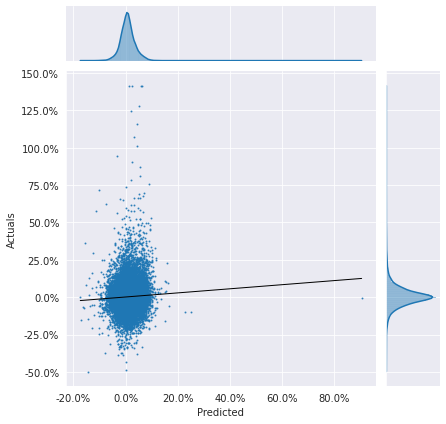

In [19]:
plot_preds_scatter(lr_predictions)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


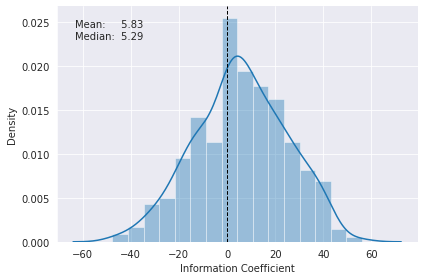

In [20]:
plot_ic_distribution(lr_scores)

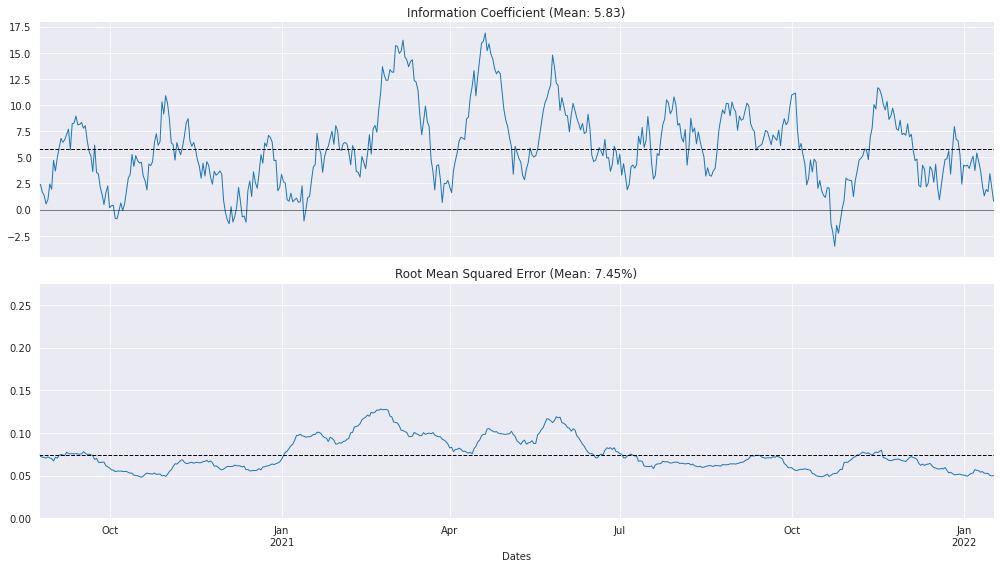

In [21]:
plot_rolling_ic(lr_scores)

In [22]:
# With Ridge Regression
ridge_alphas = np.logspace(-4, 4, 9)
#print(ridge_alphas)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))
#ridge_alphas = ridge_alphas[:11]
print(ridge_alphas)
print(len(ridge_alphas))

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]
18


In [23]:
n_splits = int(2 * YEAR/test_period_length)
train_period_length = 30
test_period_length = 7
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [24]:
target = f'target_{lookahead}d'
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [25]:
%%time
# Cross Validation with Ridge
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')], axis=1)

            ridge_scores.append(scores.assign(alpha=alpha))
            ridge_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

    except IndexError: 
        print('Ran out of data for train/test splits')
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 Ran out of data for train/test splits
0.0005 Ran out of data for train/test splits
0.001 Ran out of data for train/test splits
0.005 Ran out of data for train/test splits
0.01 Ran out of data for train/test splits
0.05 Ran out of data for train/test splits
0.1 Ran out of data for train/test splits
0.5 Ran out of data for train/test splits
1.0 Ran out of data for train/test splits
5.0 Ran out of data for train/test splits
10.0 Ran out of data for train/test splits
50.0 Ran out of data for train/test splits
100.0 Ran out of data for train/test splits
500.0 Ran out of data for train/test splits
1000.0 Ran out of data for train/test splits
5000.0 Ran out of data for train/test splits
10000.0 Ran out of data for train/test splits
50000.0 Ran out of data for train/test splits


CPU times: user 1min 32s, sys: 3min 26s, total: 4min 58s
Wall time: 38 s


In [26]:
# Save the ridge results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')

#  Reload the data
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')


In [27]:
# Evaluate the Ridge Results 
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 4.009% (p-value: 0.0000%)


In [28]:
# Ridge Alpha IC scores
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,532.0,5.825912,19.101947,-47.587150,-7.539303,5.287081,19.244703,56.015038
0.0005,532.0,5.826310,19.102074,-47.587150,-7.539303,5.287081,19.244703,56.015038
0.0010,532.0,5.826747,19.102308,-47.587150,-7.539303,5.287081,19.244703,56.015038
0.0050,532.0,5.826593,19.104481,-47.587150,-7.539303,5.287081,19.244703,56.015038
0.0100,532.0,5.828173,19.105194,-47.587150,-7.539303,5.287081,19.244703,56.015038
0.0500,532.0,5.833968,19.106786,-47.587150,-7.539303,5.375940,19.244703,56.015038
0.1000,532.0,5.835959,19.108267,-47.470950,-7.544429,5.375940,19.244703,56.103896
0.5000,532.0,5.870007,19.131394,-47.525632,-7.402597,5.451128,19.424129,56.377307
1.0000,532.0,5.893891,19.145403,-47.682843,-7.318865,5.457963,19.588175,56.527683


In [29]:
ridge_scores.groupby('alpha').rmse.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,532.0,0.074378,0.035828,0.025120,0.050022,0.065898,0.088341,0.271286
0.0005,532.0,0.074378,0.035828,0.025120,0.050022,0.065898,0.088341,0.271286
0.0010,532.0,0.074378,0.035828,0.025120,0.050022,0.065898,0.088341,0.271286
0.0050,532.0,0.074377,0.035828,0.025120,0.050022,0.065898,0.088341,0.271285
0.0100,532.0,0.074377,0.035828,0.025120,0.050022,0.065898,0.088341,0.271285
0.0500,532.0,0.074376,0.035829,0.025120,0.050021,0.065897,0.088341,0.271279
0.1000,532.0,0.074374,0.035829,0.025119,0.050021,0.065897,0.088340,0.271272
0.5000,532.0,0.074365,0.035830,0.025115,0.050019,0.065895,0.088336,0.271222
1.0000,532.0,0.074358,0.035829,0.025111,0.050017,0.065892,0.088330,0.271168


In [30]:
ridge_scores.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9576 entries, 2022-01-11 to 2020-08-10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ic      9576 non-null   float64
 1   rmse    9576 non-null   float64
 2   alpha   9576 non-null   float64
dtypes: float64(3)
memory usage: 299.2 KB


In [31]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
ridge_scores['Dates'] = ridge_scores.index
len_df = ridge_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
ridge_scores.index = temp_new_index

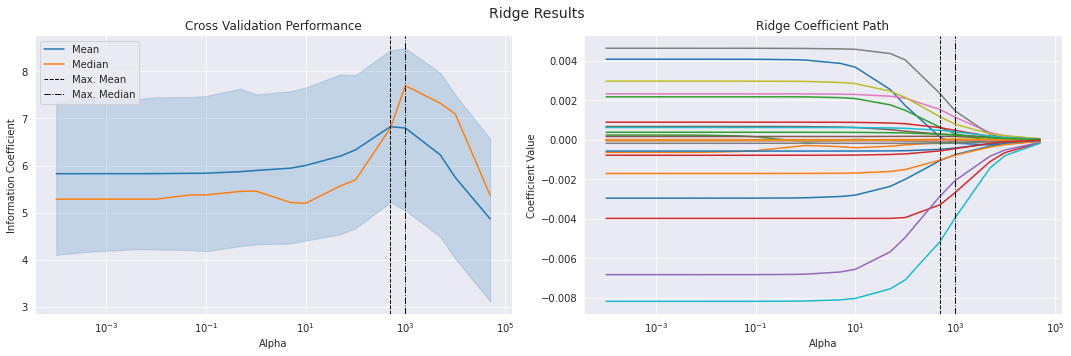

In [32]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()



ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [33]:
# Switch the index back to DateTimeIndex
#ridge_scores.index = ridge_scores['Dates']
#ridge_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


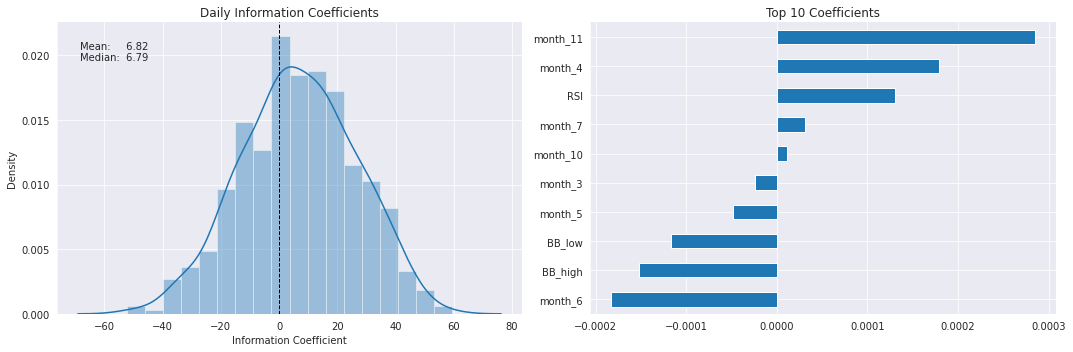

In [34]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

These observations are meant to draw conclusions about the relative importance of the coefficients by commparing their absolute magnitude. The top 10 most relevant coefficients based on the IC mean are on the right, averaged over all the trained models.

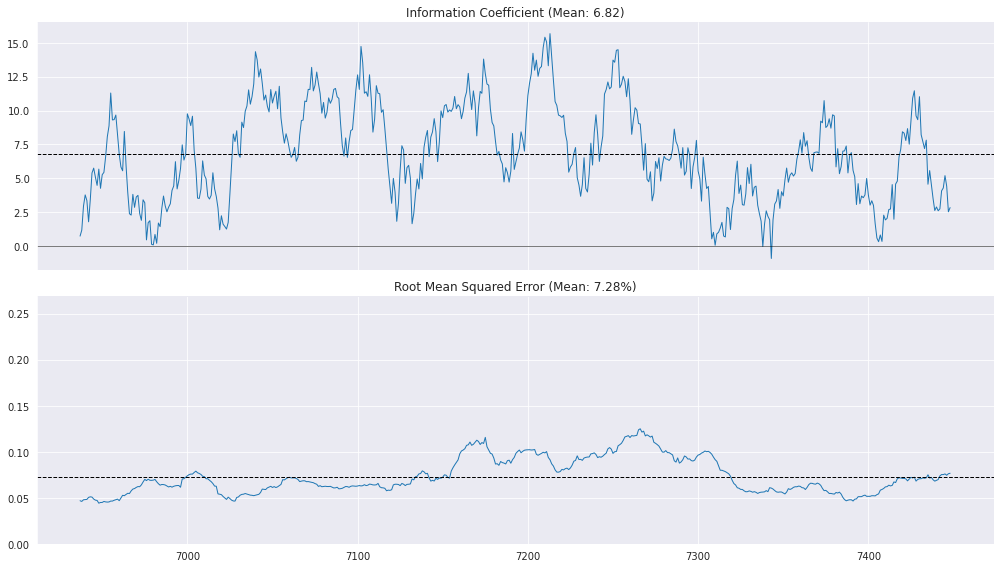

In [35]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [36]:
# With Lasso Regression

# CV parameters
lasso_alphas = np.logspace(-10, 1, 8)
#lasso_alphas = sorted(list(lasso_alphas) + list(lasso_alphas * 5))

print(lasso_alphas)
print(len(lasso_alphas))

train_period_length = 30
test_period_length = 7
YEAR = 365
n_splits = int(2 * YEAR / test_period_length) # two years
lookahead = 1


[1.00000000e-10 3.72759372e-09 1.38949549e-07 5.17947468e-06
 1.93069773e-04 7.19685673e-03 2.68269580e-01 1.00000000e+01]
8


In [37]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [38]:
# Lasso Cross-validation
target = f'target_{lookahead}d'
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [39]:
%%time
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            t = time()
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')],
                               axis=1)

            lasso_scores.append(scores.assign(alpha=alpha))
            lasso_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)
    except IndexError: 
        print('Ran out of data for train/test splits')
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+00, tolerance: 4.248e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e+00, tolerance: 4.188e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+00, tolerance: 6.570e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.292e+00, tolerance: 7.074e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e+01, tolerance: 2.910e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.085e+01, tolerance: 2.427e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e+00, tolerance: 8.854e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.258e+00, tolerance: 9.282e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
3.727593720314938e-09 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e+00, tolerance: 4.248e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e+00, tolerance: 4.188e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e+00, tolerance: 7.189e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.640e-01, tolerance: 6.570e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e-01, tolerance: 2.910e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e-01, tolerance: 1.828e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.716e+00, tolerance: 1.056e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.154e-02, tolerance: 9.384e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
1.389495494373136e-07 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+00, tolerance: 5.342e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+00, tolerance: 4.248e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e+00, tolerance: 8.056e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.278e+00, tolerance: 9.770e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e+00, tolerance: 5.128e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.329e+00, tolerance: 5.723e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
5.179474679231212e-06 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.733e-02, tolerance: 5.342e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-01, tolerance: 4.248e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-02, tolerance: 1.527e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e-01, tolerance: 6.445e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
0.00019306977288832496 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e-02, tolerance: 9.334e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.108e-02, tolerance: 6.767e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
0.007196856730011514 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e-02, tolerance: 6.461e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e-02, tolerance: 5.342e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation co

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e-02, tolerance: 8.014e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e-02, tolerance: 8.5

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e-02, tolerance: 1.539e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e-02, tolerance: 1.527e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e-02, tolerance: 8.854e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.957e-02, tolerance: 9.282e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mig

Ran out of data for train/test splits
0.26826957952797276 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e-02, tolerance: 8.045e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.392e-02, tolerance: 6.4

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

Ran out of data for train/test splits
10.0 

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRCons

Ran out of data for train/test splits
CPU times: user 1min 26s, sys: 3min 44s, total: 5min 10s
Wall time: 40 s


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [40]:
# Persist Lasso outputs
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(f'{model_dataDir}Lasso_Coeffs.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')



In [41]:
# Results
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 5.949% (p-value: 0.0000%)


In [42]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,5.867990,5.382775
3.727594e-09,5.867605,5.382775
1.389495e-07,5.870637,5.451128
5.179475e-06,5.895852,5.416951
1.930698e-04,6.176903,5.348599
7.196857e-03,5.762292,4.955571
2.682696e-01,NaN,NaN
1.000000e+01,NaN,NaN


In [43]:
lasso_scores.groupby('alpha').rmse.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,0.074348,0.065836
3.727594e-09,0.074347,0.065836
1.389495e-07,0.074331,0.065836
5.179475e-06,0.074262,0.065843
1.930698e-04,0.074004,0.066051
7.196857e-03,0.071713,0.063080
2.682696e-01,0.071681,0.062452
1.000000e+01,0.071681,0.062452


In [44]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
lasso_scores['Dates'] = lasso_scores.index
len_df = lasso_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
lasso_scores.index = temp_new_index

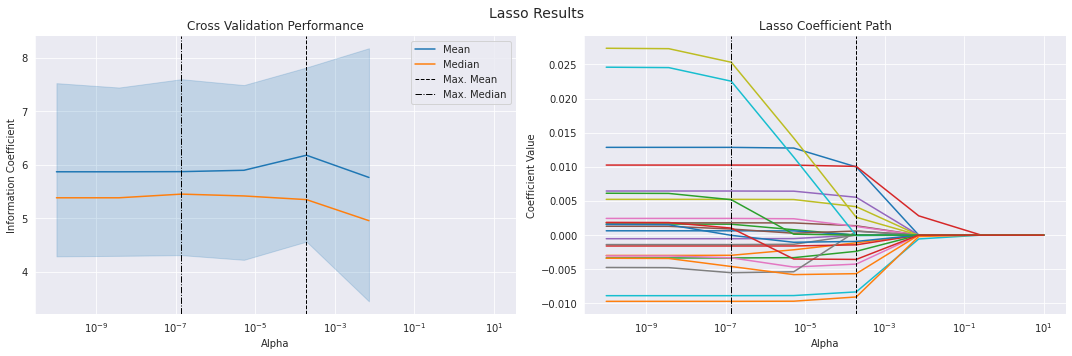

In [45]:
# Lasso Coefficient paths
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

In [46]:
# Switch the index back to DateTimeIndex
#lasso_scores.index = lasso_scores['Dates']
#lasso_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


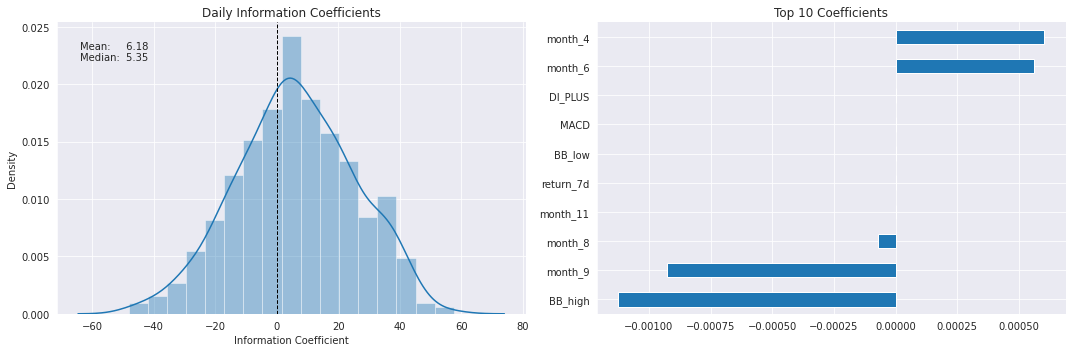

In [47]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

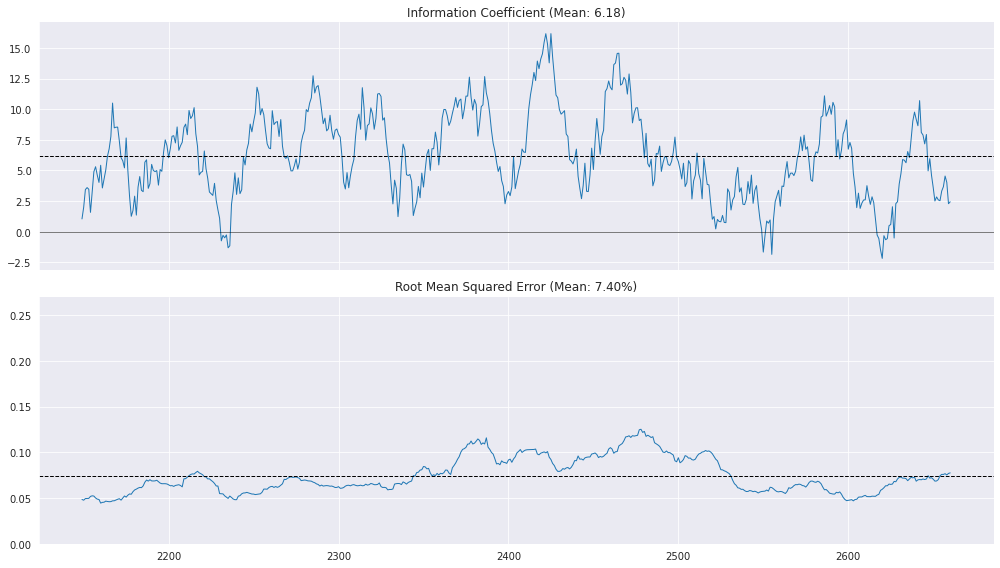

In [48]:
plot_rolling_ic(lasso_scores[lasso_scores.alpha==best_alpha])

In [49]:
# Switch the index back to DateTimeIndex
lasso_scores.index = lasso_scores['Dates']
lasso_scores.drop(['Dates'], axis = 1,inplace=True)
# Switch the index back to DateTimeIndex
ridge_scores.index = ridge_scores['Dates']
ridge_scores.drop(['Dates'], axis = 1,inplace=True)

In [50]:
# Compare results
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [51]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [52]:
lr_scores

,ic,rmse
Dates,,
2022-01-11,8.769651,0.053274
2022-01-12,-0.492139,0.032799
2022-01-13,17.997266,0.039721
2022-01-14,-8.475735,0.029998
2022-01-15,-1.257690,0.035845
...,...,...
2020-08-06,10.587833,0.056802
2020-08-07,24.128503,0.088428
2020-08-08,2.399180,0.051426


In [53]:
best_ridge_scores

,ic,rmse,alpha
Dates,,,
2022-01-11,26.445660,0.052399,500.0
2022-01-12,-7.047163,0.031923,500.0
2022-01-13,-5.625427,0.036454,500.0
2022-01-14,-2.221463,0.026762,500.0
2022-01-15,-13.889269,0.033056,500.0
...,...,...,...
2020-08-06,10.164046,0.054754,500.0
2020-08-07,15.181135,0.092963,500.0
2020-08-08,0.881750,0.053539,500.0


In [54]:
best_lasso_scores

,ic,rmse,alpha
Dates,,,
2022-01-11,15.707450,0.052949,0.000193
2022-01-12,-3.397129,0.032531,0.000193
2022-01-13,7.949419,0.039111,0.000193
2022-01-14,-5.358852,0.029266,0.000193
2022-01-15,-2.146275,0.035082,0.000193
...,...,...,...
2020-08-06,13.540670,0.055316,0.000193
2020-08-07,23.718387,0.093605,0.000193
2020-08-08,2.542720,0.054991,0.000193


In [55]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

In [56]:
df

,IC,RMSE,Model
Dates,,,
2022-01-11,8.769651,0.053274,Linear Regression
2022-01-12,-0.492139,0.032799,Linear Regression
2022-01-13,17.997266,0.039721,Linear Regression
2022-01-14,-8.475735,0.029998,Linear Regression
2022-01-15,-1.257690,0.035845,Linear Regression
...,...,...,...
2020-08-06,13.540670,0.055316,Lasso Regression
2020-08-07,23.718387,0.093605,Lasso Regression
2020-08-08,2.542720,0.054991,Lasso Regression


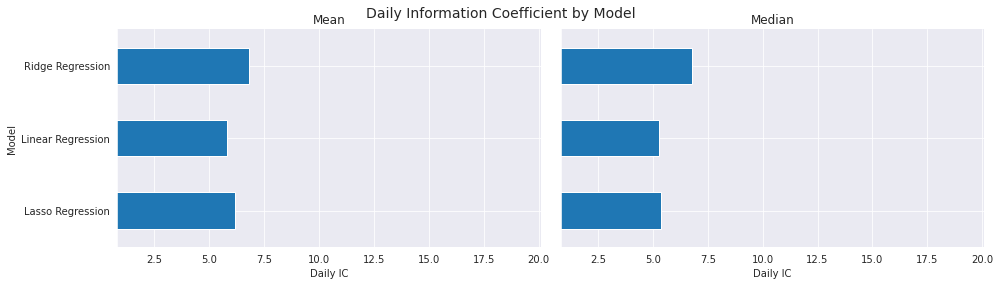

In [57]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(0.85, 20), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(0.8, 20.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)